In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import regex as re

# TODO
- drop unnecessary columns
- drop duplicates
- manage outliers
- manage null values
---
- combine cats and dogs in to a single column (pets_allowed maybe?)
- encode 'region', 'type', 'laundry_options', 'parking_options', 'state' categorical features

encoding "region" might be unnecessary, but we will see

In [79]:
df = pd.read_csv("main_raw.csv")

In [80]:
df.head(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,...,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       265190 non-null  int64  
 1   url                      265190 non-null  object 
 2   region                   265190 non-null  object 
 3   region_url               265190 non-null  object 
 4   price                    265190 non-null  int64  
 5   type                     265190 non-null  object 
 6   sqfeet                   265190 non-null  int64  
 7   beds                     265190 non-null  int64  
 8   baths                    265190 non-null  float64
 9   cats_allowed             265190 non-null  int64  
 10  dogs_allowed             265190 non-null  int64  
 11  smoking_allowed          265190 non-null  int64  
 12  wheelchair_access        265190 non-null  int64  
 13  electric_vehicle_charge  265190 non-null  int64  
 14  come

In [82]:
df.isna().sum()

id                             0
url                            0
region                         0
region_url                     0
price                          0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options            54311
parking_options            95135
image_url                      0
description                    2
lat                         1419
long                        1419
state                          1
dtype: int64

---

## Dropping columns and duplicates

#### Dropping Irrelevant Columns

In [83]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

In [84]:
df = df.drop(columns=["id", "url", "region_url", "image_url"])

#### Dropping Duplicates

In [85]:
df[df.duplicated()].head(2)

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state
45,birmingham,659,apartment,890,2,1.0,1,1,1,0,0,0,laundry on site,NaN,Are you looking for a quiet place to call home...,33.6493,-86.7057,al
46,birmingham,659,apartment,890,2,1.0,1,1,1,0,0,0,laundry on site,NaN,Are you looking for a quiet place to call home...,33.6493,-86.7057,al


In [86]:
df.duplicated().sum()

47216

lots of duplicated rows

In [87]:
# before dropping duplicates
df.shape[0]

265190

In [88]:
df = df.drop_duplicates(keep="first")

In [89]:
# after dropping duplicates
df.shape[0]

217974

---

## Outliers

price, sqfeet, beds, baths columns has outliers

In [90]:
# storing the amount of rows before dropping any outliers
w_outliers = df.shape[0]

In [91]:
# creating some helper functions to use it in every feature

def find_iqr_and_fences(df, feature):
    iqr = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    upper_fence = df[feature].quantile(0.75) + 1.5 * iqr
    lower_fence = df[feature].quantile(0.25) - 1.5 * iqr
    
    print(f"{feature} feature's IQR: {iqr}")    
    print(f"Samples above with value {upper_fence} should be dropped")
    print(f"Amount of outliers detected in upper region: {df[df[feature] > upper_fence].shape[0]}\n")
    
    print(f"Samples below with value {lower_fence} should be dropped")
    print(f"Amount of outliers detected in lower region: {df[df[feature] < lower_fence].shape[0]}")
    
    return lower_fence, upper_fence
    
def outlier_viz(df, feature):
    print(df[feature].describe())
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=80)
    
    gs = ax[0, 0].get_gridspec()
    # # remove the wanted axes
    ax[0, 1].remove()

    axwide = fig.add_subplot(gs[0, 0:])

    axwide.boxplot(df[feature], vert=False)
    axwide.set_title(f"Box Plot of the {feature} feature")

    ax[1, 0].hist(df[feature])
    ax[1, 0].set_title(f"Histogram Plot of the {feature} feature")

    ax[1, 1].plot(df[feature].sort_values().reset_index().drop("index", axis=1), ls=":", lw=2)
    ax[1, 1].set_title(f"Quantile Like Plot of the {feature} feature");

    plt.tight_layout()
    plt.show()
    

### price Feature

count    2.179740e+05
mean     1.461851e+04
std      5.929993e+06
min      0.000000e+00
25%      8.500000e+02
50%      1.109000e+03
75%      1.499000e+03
max      2.768307e+09
Name: price, dtype: float64


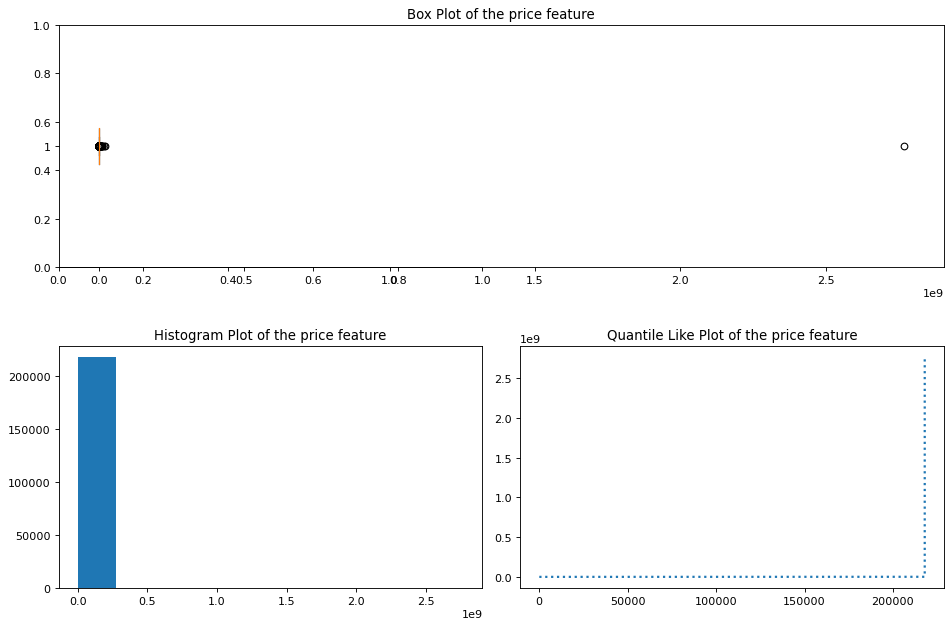

In [92]:
# before dropping outliers
outlier_viz(df, "price")

minimum price of zero is concerning, therefore I am going to investigate the lower bound of this feature first

In [93]:
df[df.price == 0].price

1735      0
1741      0
7049      0
7286      0
8171      0
         ..
264881    0
265094    0
265151    0
265180    0
265185    0
Name: price, Length: 589, dtype: int64

In [94]:
# I set the lower bound to be 400 USD
df[df.price < 400].price

634       344
635       300
641       300
643       344
722       295
         ... 
264965     55
265094      0
265151      0
265180      0
265185      0
Name: price, Length: 2658, dtype: int64

In [95]:
df = df[df.price >= 400]

In [96]:
lower, upper = find_iqr_and_fences(df, "price")

price feature's IQR: 645.0
Samples above with value 2467.5 should be dropped
Amount of outliers detected in upper region: 11057

Samples below with value -112.5 should be dropped
Amount of outliers detected in lower region: 0


count    204259.000000
mean       1170.594304
std         429.736004
min         400.000000
25%         849.000000
50%        1090.000000
75%        1425.000000
max        2467.000000
Name: price, dtype: float64


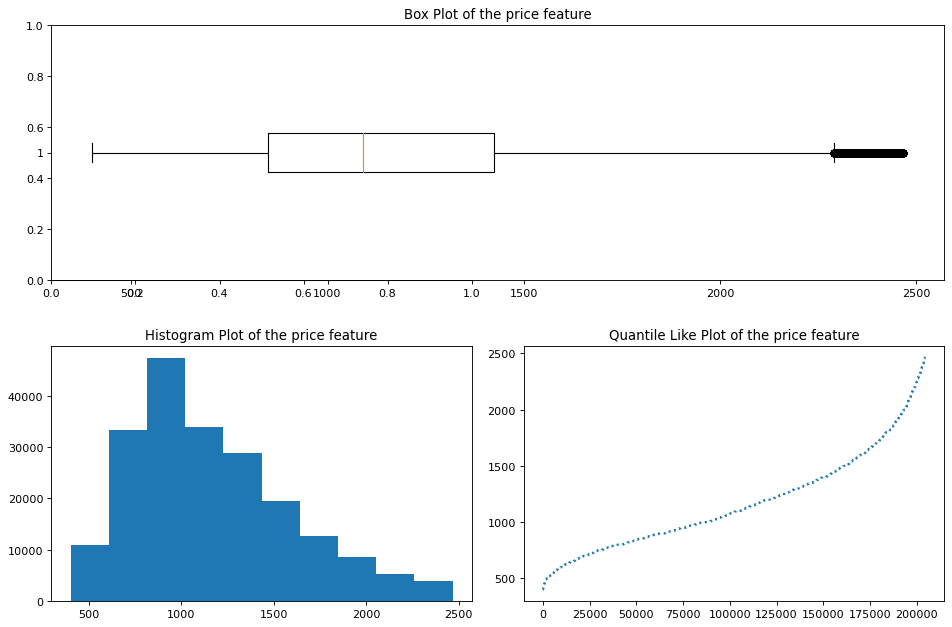

In [97]:
# after dropping outliers
df = df[df.price <= upper]
outlier_viz(df, "price")

### sqfeet Feature

count    2.042590e+05
mean     1.098807e+03
std      2.608873e+04
min      0.000000e+00
25%      7.520000e+02
50%      9.500000e+02
75%      1.150000e+03
max      8.388607e+06
Name: sqfeet, dtype: float64


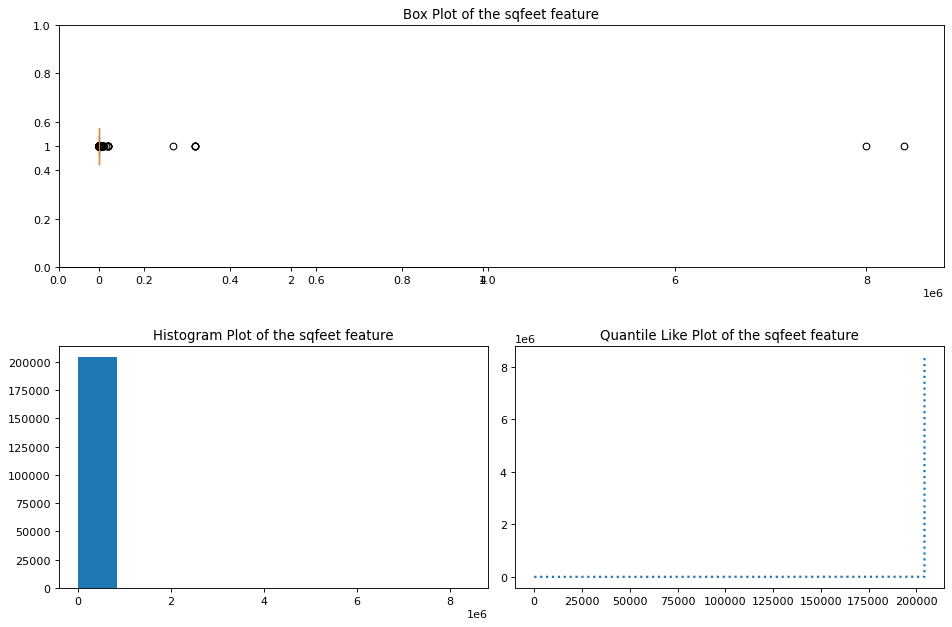

In [98]:
# before dropping outliers
outlier_viz(df, "sqfeet")

In [99]:
df[df.sqfeet < 500].sqfeet

423       230
426       230
681         1
762       300
765       300
         ... 
264818    255
264822    450
264911    430
264922      2
265148    300
Name: sqfeet, Length: 6289, dtype: int64

In [100]:
df = df[df.sqfeet >= 500]

In [101]:
lower, upper = find_iqr_and_fences(df, "sqfeet")

sqfeet feature's IQR: 378.0
Samples above with value 1720.0 should be dropped
Amount of outliers detected in upper region: 7407

Samples below with value 208.0 should be dropped
Amount of outliers detected in lower region: 0


In [102]:
df = df[(lower <= df.sqfeet) & (df.sqfeet <= upper)]

count    190563.000000
mean        964.325430
std         255.417078
min         500.000000
25%         766.000000
50%         950.000000
75%        1121.000000
max        1720.000000
Name: sqfeet, dtype: float64


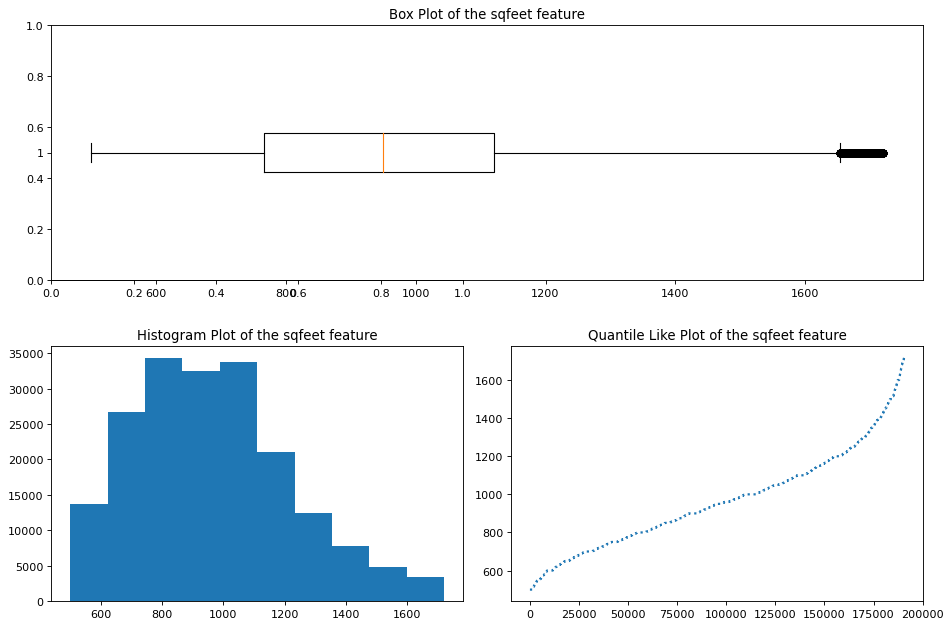

In [103]:
# after dropping outliers
outlier_viz(df, "sqfeet")

### beds Feature

count    190563.000000
mean          1.868101
std           2.633363
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1100.000000
Name: beds, dtype: float64


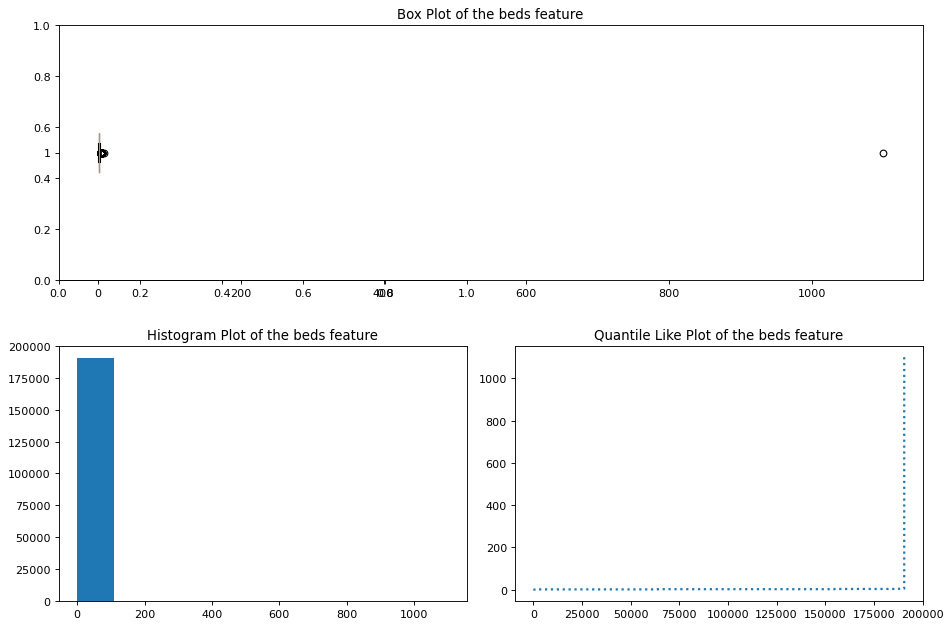

In [104]:
# before dropping outliers
outlier_viz(df, "beds")

In [105]:
lower, upper = find_iqr_and_fences(df, "beds")

beds feature's IQR: 1.0
Samples above with value 3.5 should be dropped
Amount of outliers detected in upper region: 3642

Samples below with value -0.5 should be dropped
Amount of outliers detected in lower region: 0


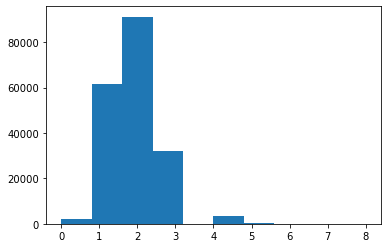

In [106]:
# checking if the upper bound is meaningful
plt.hist(df[df.beds <= 10].beds);

In [107]:
# I am adjusting the upper bound to 5 on the contrast with 3.5 suggested from the outlier detector I implemented 
df = df[(lower <= df.beds) & (df.beds <= 5)]

count    190554.000000
mean          1.862155
std           0.778255
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           5.000000
Name: beds, dtype: float64


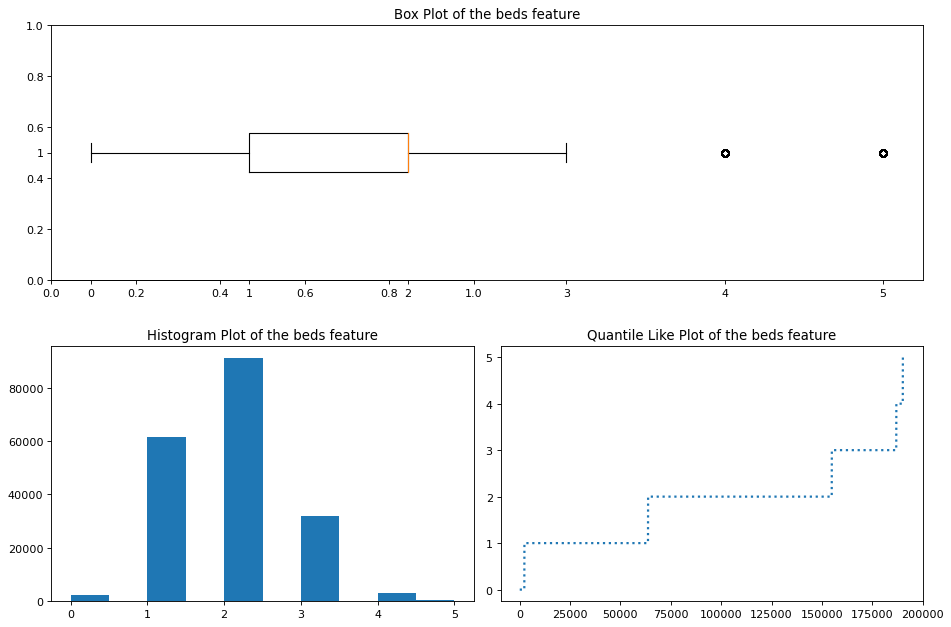

In [108]:
# after dropping outliers
outlier_viz(df, "beds")

### baths Feature

In [109]:
df.baths.value_counts()

baths
1.0    99817
2.0    69029
1.5    13302
2.5     4396
3.0     1835
0.0     1552
4.0      545
3.5       48
4.5       16
5.0       14
Name: count, dtype: int64

there are floating points

In [110]:
df.baths = df.baths.apply(np.ceil).astype(int)

count    190554.000000
mean          1.499281
std           0.593507
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: baths, dtype: float64


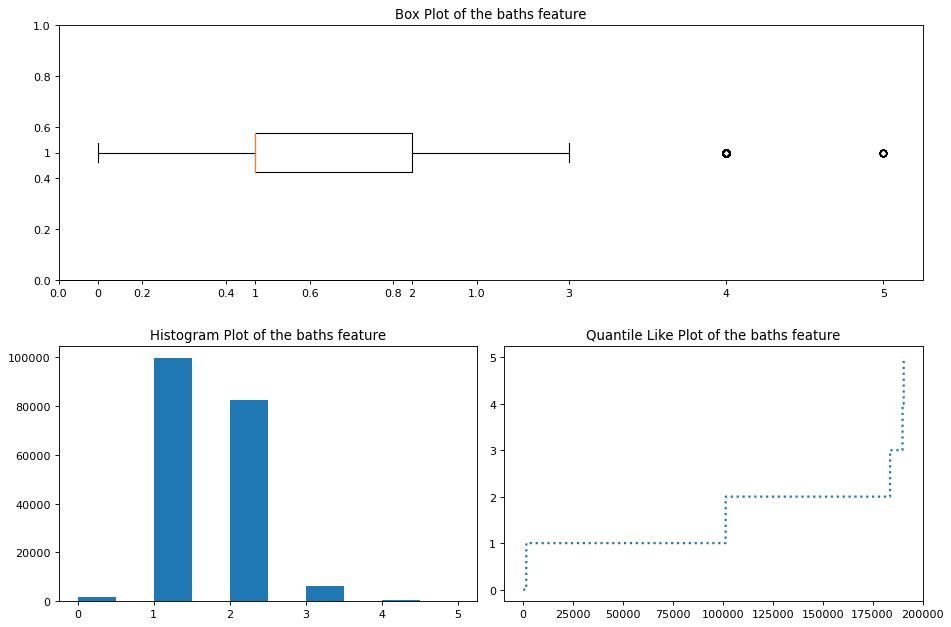

In [111]:
outlier_viz(df, "baths")

- after all of the other outlier reductions, it seems that outliers in baths feature is also affected
- we can skip baths feature due to this fact

#### Total amount of rows dropped during outliers reduction

In [112]:
w_outliers - df.shape[0]

27420

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190554 entries, 1 to 265189
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region                   190554 non-null  object 
 1   price                    190554 non-null  int64  
 2   type                     190554 non-null  object 
 3   sqfeet                   190554 non-null  int64  
 4   beds                     190554 non-null  int64  
 5   baths                    190554 non-null  int32  
 6   cats_allowed             190554 non-null  int64  
 7   dogs_allowed             190554 non-null  int64  
 8   smoking_allowed          190554 non-null  int64  
 9   wheelchair_access        190554 non-null  int64  
 10  electric_vehicle_charge  190554 non-null  int64  
 11  comes_furnished          190554 non-null  int64  
 12  laundry_options          146715 non-null  object 
 13  parking_options          115228 non-null  object 
 14  descripti

---

## Filling Null Values

In [114]:
df.isna().sum()

region                         0
price                          0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options            43839
parking_options            75326
description                    2
lat                          968
long                         968
state                          1
dtype: int64

In [115]:
df.isna().sum() / df.shape[0]

region                     0.000000
price                      0.000000
type                       0.000000
sqfeet                     0.000000
beds                       0.000000
baths                      0.000000
cats_allowed               0.000000
dogs_allowed               0.000000
smoking_allowed            0.000000
wheelchair_access          0.000000
electric_vehicle_charge    0.000000
comes_furnished            0.000000
laundry_options            0.230061
parking_options            0.395300
description                0.000010
lat                        0.005080
long                       0.005080
state                      0.000005
dtype: float64

- almost 40% of the parking_options feature is missing, which is concerning

#### Method for filling
- find the average price for each class
- fill the nulls according to the label that has the closest average price

In [116]:
def fill_nulls(feature):
    null_indexes = df[df[feature].isna()][[feature]].index
    lookup = df[["price", feature]].groupby(feature).mean().price
    
    print(lookup)

    for idx in tqdm(null_indexes):
        closest_label_idx = (lookup - df.loc[idx, "price"]).apply(abs).argmin()
        df.loc[idx, feature] = lookup.index[closest_label_idx]

In [117]:
def show_analysis(feature):
    counts = df[feature].value_counts()
    print(counts)
    df[df[feature].isna()][feature]
    
    return counts

### laundry_options

In [118]:
before_counts = show_analysis("laundry_options")

laundry_options
w/d in unit           66539
w/d hookups           35162
laundry on site       24262
laundry in bldg       19088
no laundry on site     1664
Name: count, dtype: int64


In [119]:
fill_nulls("laundry_options")

laundry_options
laundry in bldg       1031.611431
laundry on site       1073.958495
no laundry on site     994.334736
w/d hookups           1036.874524
w/d in unit           1331.128286
Name: price, dtype: float64


100%|██████████████████████████████████████████████████████████████████████████| 43839/43839 [00:24<00:00, 1802.69it/s]


In [120]:
after_counts = show_analysis("laundry_options")

laundry_options
w/d in unit           83087
w/d hookups           35944
laundry on site       29958
no laundry on site    21638
laundry in bldg       19927
Name: count, dtype: int64


In [121]:
# how many fills are done in each classes
after_counts - before_counts

laundry_options
laundry in bldg         839
laundry on site        5696
no laundry on site    19974
w/d hookups             782
w/d in unit           16548
Name: count, dtype: int64

### parking_options

In [122]:
before_counts = show_analysis("parking_options")

parking_options
off-street parking    61037
carport               19748
attached garage       16194
detached garage        9469
street parking         7670
no parking             1040
valet parking            70
Name: count, dtype: int64


In [123]:
fill_nulls("parking_options")

parking_options
attached garage       1440.189021
carport               1309.145635
detached garage       1267.157461
no parking            1210.406731
off-street parking    1061.935154
street parking        1143.335072
valet parking         1470.128571
Name: price, dtype: float64


100%|██████████████████████████████████████████████████████████████████████████| 75326/75326 [00:43<00:00, 1746.13it/s]


In [124]:
after_counts = show_analysis("parking_options")

parking_options
off-street parking    100387
carport                25125
attached garage        20153
valet parking          14617
street parking         12511
detached garage        12178
no parking              5583
Name: count, dtype: int64


In [125]:
# how many fills are done in each classes
after_counts - before_counts

parking_options
attached garage        3959
carport                5377
detached garage        2709
no parking             4543
off-street parking    39350
street parking         4841
valet parking         14547
Name: count, dtype: int64

### description

In [126]:
# dropping them since it is only 2 values
df = df.dropna(subset="description")

### lat and long

In [127]:
df["lat"].fillna(df["lat"].mean(), inplace=True)
df["long"].fillna(df["long"].mean(), inplace=True)

### state

In [128]:
# dropping since it is only 1 value
df = df.dropna(subset="state")

## Final state of the df

In [129]:
df.isna().sum()

region                     0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
description                0
lat                        0
long                       0
state                      0
dtype: int64

---

## Combining cats and dogs feature

In [130]:
df["pets_allowed"] = df.cats_allowed | df.dogs_allowed
df.drop(columns=["cats_allowed","dogs_allowed"], inplace=True)

## Creating new features from description column

In [131]:
# finding the keywords in the description column
count_dict = {}
for row in tqdm(df.description):
    words = row.lower().strip().split()
    words = [re.sub("[^\w\s]", "", w) for w in words]

    for word in words:
        if word in count_dict:
            count_dict[word] += 1
        else:
            count_dict[word] = 1

count_dict = dict(sorted(count_dict.items(), key=lambda x:x[1], reverse=True))
count_dict

100%|████████████████████████████████████████████████████████████████████████| 190551/190551 [01:26<00:00, 2191.70it/s]


{'and': 1102565,
 '': 902069,
 'the': 651302,
 'to': 636259,
 'a': 529566,
 'in': 446101,
 'with': 378210,
 'of': 358628,
 'â': 307630,
 'our': 301699,
 'for': 294496,
 'at': 269286,
 'is': 235406,
 'you': 232122,
 'community': 218052,
 'contact': 217908,
 'your': 214008,
 'apartment': 210119,
 'are': 195262,
 'info': 184626,
 'apartments': 183576,
 'or': 178823,
 'show': 178597,
 'call': 166026,
 'home': 163923,
 'center': 152064,
 'we': 148073,
 'bedroom': 145364,
 'pet': 135350,
 'on': 134832,
 '2': 131558,
 'from': 129896,
 'pool': 121707,
 'amenities': 113236,
 'new': 110762,
 'this': 110420,
 'available': 106527,
 'fitness': 103413,
 'all': 102242,
 'one': 101635,
 '1': 100509,
 'rent': 100341,
 'living': 99743,
 'park': 98219,
 'access': 97768,
 'features': 97698,
 'floor': 93745,
 'more': 93426,
 'two': 91741,
 'today': 91499,
 'homes': 90088,
 'kitchen': 85153,
 'area': 85006,
 'located': 84536,
 'room': 83029,
 'by': 82232,
 'spacious': 80605,
 'an': 79320,
 'parking': 79310,

some keywords that can be used for extracting new features
- pool, swim
- fitness, gym, basketball, spa, tennis
- park, garden
- mall, shop, market, grocery, store, downtown
- grill, fireplace, bbq
- school, college, university
- hospital, medical, health
- transportation, airport, station, bus, train
- security
- garage

In [132]:
df["has_pool"] = df.description.str.lower().str.contains("pool|swim").astype(int)
df["has_sports"] = df.description.str.contains("fitness|gym|basketball|spa|tennis").astype(int)
df["has_park"] = df.description.str.lower().str.replace("parking", "").str.contains("park|garden").astype(int)
df["has_shopping"] = df.description.str.contains("mall|shop|market|grocery|store|downtown").astype(int)
df["has_transportation"] = df.description.str.contains("transportation|airport|station|bus|train").astype(int)

# features below has less than 30K instances (should it be implemented?)
# df["has_grill"] = df.description.str.contains("grill|fireplace|bbq").astype(int)  # 25K instances
# df["has_eductaion"] = df.description.str.contains("school|college|university").astype(int) # 15K instances
# df["has_health"] = df.description.str.contains("hospital|medical|health").astype(int) # 5K instances!!!
# df["has_garage"] = df.description.str.contains("garage").astype(int) # 18K instances
# df["has_security"] = df.description.str.contains("security").astype(int) # 9K instances

df.drop(columns=["description"],inplace=True)

In [133]:
df.head()

,region,price,type,sqfeet,beds,baths,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,...,parking_options,lat,long,state,pets_allowed,has_pool,has_sports,has_park,has_shopping,has_transportation
1,birmingham,1120,apartment,1319,3,2,1,0,0,0,...,off-street parking,33.3755,-86.8045,al,1,0,0,0,1,0
2,birmingham,825,apartment,1133,1,2,1,0,0,0,...,street parking,33.4226,-86.7065,al,1,1,1,1,1,1
3,birmingham,800,apartment,927,1,1,1,0,0,0,...,street parking,33.4226,-86.7065,al,1,1,1,1,1,1
4,birmingham,785,apartment,1047,2,1,1,0,0,0,...,street parking,33.4226,-86.7065,al,1,1,1,1,1,1
5,birmingham,900,apartment,1298,2,2,1,0,0,0,...,street parking,33.4226,-86.7065,al,1,1,1,1,1,1


In [134]:
df.columns

Index(['region', 'price', 'type', 'sqfeet', 'beds', 'baths', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'lat', 'long', 'state',
       'pets_allowed', 'has_pool', 'has_sports', 'has_park', 'has_shopping',
       'has_transportation'],
      dtype='object')

- before advancing any further I will reset the indexes, because during the encoding part there will be different methods and these methods will yield different dataframes. Therefore, after the encoding the dataframe will be branched and reseting the indexes at this point is sensible

In [160]:
df = df.reset_index().drop(columns=["index"])

## Encoding Categorical Features
- region
- type
- laundry_options
- parking_options
- state

this is the final part of the presproccessing of the data, there will be different variations of the dataset according to the encoding method. normalizing the features will not be done here, it will be implemented in the modeling part.

---

before starting the encoding, I wanted to deal with the region feature first. Upon inspecting, I saw that there are 297 unique values in region feature. In order to encode this feature, a sensible step can be combining less occurred values as "other". I wanted to approach with this solution first, but saw that the value counts doesn't seem to lower quickly and stay similar for a quite time. Moreover, with the presence of state feature I thought that region column probably won't add more value to the data and decided to drop the region column.

In [136]:
df.region.value_counts()

region
rochester                 3019
jacksonville              2957
fayetteville              2678
orlando                   2380
denver                    2215
                          ... 
zanesville / cambridge       2
kansas city                  2
east oregon                  1
texoma                       1
northwest OK                 1
Name: count, Length: 297, dtype: int64

Text(0, 0.5, 'Occurrences')

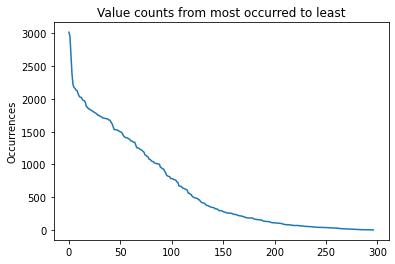

In [137]:
plt.plot(range(df.region.value_counts().size),df.region.value_counts())

plt.title("Value counts from most occurred to least")
plt.ylabel("Occurrences")
# plt.xlim((-3, 50))

- even at the 50th place of value counts, there are still around 1500 instances

In [138]:
df.drop(columns=["region"], inplace=True)

## Encoding according to the first encounter in dataset

In [139]:
cat_cols = ["type", "laundry_options", "parking_options", "state"]

even from start this method doesn't look sensible, because we label the feature according to the first occurences

In [140]:
def first_encounter_encode(feature):
    print(f"\nBEFORE:\n{df_fe_encoded[feature].value_counts()}")
    
    # using pd.factorize()
    df_fe_encoded[feature] = df_fe_encoded[feature].factorize()[0]
    
    print(f"\nAFTER:\n{df_fe_encoded[feature].value_counts()}")

In [162]:
df_fe_encoded = df.copy()

for f in cat_cols:
    first_encounter_encode(f)


BEFORE:
type
apartment        161865
house             12856
townhouse          6787
condo              3290
duplex             2525
manufactured       2120
cottage/cabin       387
loft                379
flat                245
in-law               96
land                  1
Name: count, dtype: int64

AFTER:
type
0     161865
1      12856
3       6787
4       3290
5       2525
2       2120
7        387
9        379
8        245
6         96
10         1
Name: count, dtype: int64

BEFORE:
laundry_options
w/d in unit           83086
w/d hookups           35942
laundry on site       29958
no laundry on site    21638
laundry in bldg       19927
Name: count, dtype: int64

AFTER:
laundry_options
1    83086
3    35942
0    29958
2    21638
4    19927
Name: count, dtype: int64

BEFORE:
parking_options
off-street parking    100387
carport                25125
attached garage        20152
valet parking          14616
street parking         12511
detached garage        12177
no parking         

In [165]:
df_fe_encoded

,price,type,sqfeet,beds,baths,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,state,pets_allowed,has_pool,has_sports,has_park,has_shopping,has_transportation
0,1120,0,1319,3,2,1,0,0,0,0,0,33.3755,-86.8045,0,1,0,0,0,1,0
1,825,0,1133,1,2,1,0,0,0,0,1,33.4226,-86.7065,0,1,1,1,1,1,1
2,800,0,927,1,1,1,0,0,0,0,1,33.4226,-86.7065,0,1,1,1,1,1,1
3,785,0,1047,2,1,1,0,0,0,0,1,33.4226,-86.7065,0,1,1,1,1,1,1
4,900,0,1298,2,2,1,0,0,0,0,1,33.4226,-86.7065,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190546,870,0,933,2,2,1,0,0,0,3,1,39.8971,-82.8957,34,1,0,0,1,0,0
190547,929,0,728,1,1,1,1,0,0,1,0,39.9709,-82.9241,34,1,0,1,0,1,1
190548,1069,0,1020,2,2,1,0,0,0,3,2,39.8408,-83.0804,34,1,1,0,1,0,0
190549,1507,0,1660,2,2,1,0,0,0,1,5,40.0564,-83.0417,34,1,1,0,1,0,1


In [166]:
df_fe_encoded.to_csv("main_fe_encoded.csv", index=False)

## Ordinal encoding according to the target feature

intuition is that, if a category has a bigger price average it should have a bigger numerical value, this brings some sort of ordinal sense among the feature

In [144]:
def ordinal_encode(feature):
    print(f"\nBEFORE:\n{df_ordinal_encoded[feature].value_counts()}")
    
    # finding and ordering the categories of the feature according to the average price
    # finally gathering the indexes for creating a mapper
    ordered_labels = df_ordinal_encoded[[feature,"price"]].groupby(feature).mean().sort_values("price").index
    
    # creating a mapper to use it to map the values
    mapper = {}
    for idx, label in enumerate(ordered_labels):
        mapper[label] = idx
    
    # mapping
    df_ordinal_encoded[feature] = df_ordinal_encoded[feature].map(mapper)
    
    print(f"\nAFTER:\n{df_ordinal_encoded[feature].value_counts()}")

In [145]:
df_ordinal_encoded = df.copy()

for f in cat_cols:
    ordinal_encode(f)


BEFORE:
type
apartment        161865
house             12856
townhouse          6787
condo              3290
duplex             2525
manufactured       2120
cottage/cabin       387
loft                379
flat                245
in-law               96
land                  1
Name: count, dtype: int64

AFTER:
type
4     161865
2      12856
6       6787
9       3290
3       2525
1       2120
5        387
7        379
10       245
8         96
0          1
Name: count, dtype: int64

BEFORE:
laundry_options
w/d in unit           83086
w/d hookups           35942
laundry on site       29958
no laundry on site    21638
laundry in bldg       19927
Name: count, dtype: int64

AFTER:
laundry_options
4    83086
2    35942
3    29958
0    21638
1    19927
Name: count, dtype: int64

BEFORE:
parking_options
off-street parking    100387
carport                25125
attached garage        20152
valet parking          14616
street parking         12511
detached garage        12177
no parking         

In [146]:
df_ordinal_encoded.head()

,price,type,sqfeet,beds,baths,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,state,pets_allowed,has_pool,has_sports,has_park,has_shopping,has_transportation
1,1120,4,1319,3,2,1,0,0,0,3,0,33.3755,-86.8045,7,1,0,0,0,1,0
2,825,4,1133,1,2,1,0,0,0,3,1,33.4226,-86.7065,7,1,1,1,1,1,1
3,800,4,927,1,1,1,0,0,0,3,1,33.4226,-86.7065,7,1,1,1,1,1,1
4,785,4,1047,2,1,1,0,0,0,3,1,33.4226,-86.7065,7,1,1,1,1,1,1
5,900,4,1298,2,2,1,0,0,0,3,1,33.4226,-86.7065,7,1,1,1,1,1,1


In [167]:
df_ordinal_encoded.to_csv("main_ordinal_encoded.csv", index=False)

## One-hot encoding

In [148]:
df_onehot = pd.get_dummies(df, dtype=int, drop_first=True)

In [149]:
df_onehot.columns

Index(['price', 'sqfeet', 'beds', 'baths', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'lat', 'long', 'pets_allowed', 'has_pool', 'has_sports', 'has_park',
       'has_shopping', 'has_transportation', 'type_condo',
       'type_cottage/cabin', 'type_duplex', 'type_flat', 'type_house',
       'type_in-law', 'type_land', 'type_loft', 'type_manufactured',
       'type_townhouse', 'laundry_options_laundry on site',
       'laundry_options_no laundry on site', 'laundry_options_w/d hookups',
       'laundry_options_w/d in unit', 'parking_options_carport',
       'parking_options_detached garage', 'parking_options_no parking',
       'parking_options_off-street parking', 'parking_options_street parking',
       'parking_options_valet parking', 'state_al', 'state_ar', 'state_az',
       'state_ca', 'state_co', 'state_ct', 'state_dc', 'state_de', 'state_fl',
       'state_ga', 'state_hi', 'state_ia', 'state_id', 'state_il', 'state_in',
   

In [168]:
df_onehot.to_csv("main_onehot_encoded.csv", index=False)